# Named Entity Recognition
In Natural Language Processing (NLP) an Entity Recognition is one of the common problem. The entity is referred to as the part of the text that is interested in. In NLP, NER is a method of extracting the relevant information from a large corpus and classifying those entities into predefined categories such as location, organization, name and so on. Information about lables:

* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

  1. Total Words Count = 1354149 
  2. Target Data Column: Tag

In [1]:
import pandas as pd
import numpy as np

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional
from keras.models import Model, Input, Sequential
from keras_contrib.layers import CRF
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

# from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.metrics import f1_score
# from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence
import pickle

Using TensorFlow backend.


In [2]:
# Reading the data
df = pd.read_csv('./entity-annotated-corpus/ner_dataset.csv', encoding='ISO-8859-1')

In [3]:
# Explore the data
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


In [4]:
df.describe()

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 26719,the,NN,O
freq,1,52573,145807,887908


In [5]:
# Number of unique Tags
df['Tag'].unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [6]:
# Checking NaN values
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

In [7]:
# Removing NaN values using fillna
df = df.fillna(method='ffill')

In [8]:
# Check if there is no NaN
df.isnull().sum()

Sentence #    0
Word          0
POS           0
Tag           0
dtype: int64

In [9]:
# Number of unique words
len(df['Word'].unique())

35178

In [10]:
# Number of sentences
len(df['Sentence #'].unique())

47959

In [11]:
# Get the full sentence along with POS and Tags
class Sentence:
    def __init__(self, df):
        self.df = df
        agg = lambda s : [
            (
                w, p, t) for w, p, t in zip(
                s['Word'].values.tolist(), 
                s['POS'].values.tolist(), 
                s['Tag'].values.tolist()
            )
        ]
        self.grouped = self.df.groupby('Sentence #').apply(agg)
        self.sentences = [s for s in self.grouped]

In [12]:
# Get the sentences along with its POS and Tag
sentence = Sentence(df)
sent1 = sentence.sentences[0]
print(sent1)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [13]:
# Print out a demo sentence
demo_sent = ' '.join(tup[0] for tup in sent1)
print(demo_sent)

Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .


In [14]:
# Get all the sentences w/o tags
sentences = [' '.join(tup[0] for tup in sent) for sent in sentence.sentences]

In [15]:
# Check
sentences[0]

'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .'

In [16]:
# Get all the sentenes w/ tags
sentences = sentence.sentences

In [17]:
# Check
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

In [18]:
# Define the LSTM network
batch_size = 64
max_len = 100
epochs = 10
embedding = 100

In [19]:
# Data preprocessing -- Converting words and tags to OHE [In production use something like Word2Vec, GloVe or BERT]
words = list(df['Word'].unique())
tags = list(df['Tag'].unique())
word_to_index = {w : i + 2 for i, w in enumerate(words)}
word_to_index["UNK"] = 1
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0
idx2word = {i: w for w, i in word_to_index.items()}
idx2tag = {i: w for w, i in tag_to_index.items()}

In [20]:
# Convert all the sentences to OHE
X = [[word_to_index[w[0]] for w in sent] for sent in sentences]

In [21]:
# Padding so that each word has same length -- add 0s
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=word_to_index["PAD"])

In [22]:
# Convert tag labels to OHE
y = [[tag_to_index[w[2]] for w in s] for s in sentences]

# Padding
y = pad_sequences(maxlen = max_len, sequences = y, padding = "post", value = tag_to_index["PAD"])

In [23]:
num_tag = df['Tag'].nunique()
y = [to_categorical(i, num_classes=num_tag + 1) for i in y]

In [24]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15)

In [25]:
X_train.shape

(40765, 100)

In [26]:
np.array(y_train).shape

(40765, 100, 18)

In [35]:
num_tags = df['Tag'].nunique()
# Model architecture
input = Input(shape = (max_len,))
model = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len)(input)
model = Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(model)
model = TimeDistributed(Dense(50, activation="relu"))(model)
crf = CRF(num_tags+1)  # CRF layer
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

/Users/mayank/develop/env/venv_ml/lib/python3.6/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/mayank/develop/env/venv_ml/lib/python3.6/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 100, 100)          3518000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 100, 50)           5050      
_________________________________________________________________
crf_4 (CRF)                  (None, 100, 18)           1278      
Total params: 3,584,728
Trainable params: 3,584,728
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Saving the best model while training
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [37]:
# History to plot the progress
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=epochs,
                    validation_split=0.1, callbacks=[checkpointer])

/Users/mayank/develop/env/venv_ml/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 36688 samples, validate on 4077 samples
Epoch 1/10
36688/36688 [==============================] - 148s 4ms/step - loss: 0.1106 - crf_viterbi_accuracy: 0.9721 - val_loss: 0.0274 - val_crf_viterbi_accuracy: 0.9905
Epoch 2/10
36688/36688 [==============================] - 135s 4ms/step - loss: 0.0179 - crf_viterbi_accuracy: 0.9922 - val_loss: 0.0122 - val_crf_viterbi_accuracy: 0.9928
Epoch 3/10
36688/36688 [==============================] - 135s 4ms/step - loss: 0.0062 - crf_viterbi_accuracy: 0.9937 - val_loss: 0.0048 - val_crf_viterbi_accuracy: 0.9930
Epoch 4/10
36688/36688 [==============================] - 135s 4ms/step - loss: -0.0022 - crf_viterbi_accuracy: 0.9944 - val_loss: -0.0022 - val_crf_viterbi_accuracy: 0.9932
Epoch 5/10
36688/36688 [==============================] - 135s 4ms/step - loss: -0.0096 - crf_viterbi_accuracy: 0.9948 - val_loss: -0.0086 - val_crf_viterbi_accuracy: 0.9932
Epoch 6/10
36688/36688 [==============================] - 135s 4ms/step - loss: -0.0166

In [38]:
history.history.keys()

dict_keys(['val_loss', 'val_crf_viterbi_accuracy', 'loss', 'crf_viterbi_accuracy'])

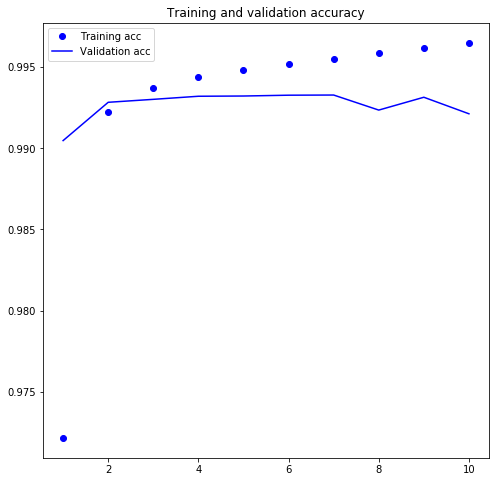

In [39]:
acc = history.history['crf_viterbi_accuracy']
val_acc = history.history['val_crf_viterbi_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (8, 8))
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

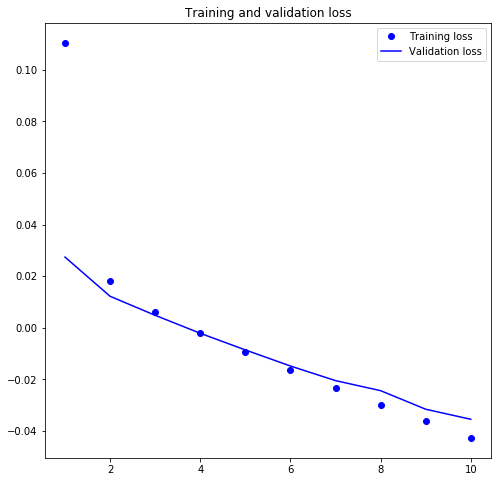

In [40]:
plt.figure(figsize = (8, 8))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [41]:
# Evaluation
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=-1)
y_test_true = np.argmax(y_test, -1)

In [45]:
# Convert the index to tag
y_pred = [[idx2tag[i] for i in row] for row in y_pred]
y_test_true = [[idx2tag[i] for i in row] for row in y_test_true]